# Práctico

El trabajo práctico de la materia consiste en el análisis de un conjunto de datos extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

## Configuración inicial

In [1]:
import seaborn as sns

In [2]:
import pandas as pd
from pathlib import Path
import networkx as nx
import igraph as ig

import matplotlib.pyplot as plt
import numpy as np
from time import time

## Descargar el csv con los datos en este directorio
DATA_DIR = Path('./data')
INPUT_FILE = DATA_DIR / 'vacunas.csv'

## Creamos el directorio en caso de que no exista
DATA_DIR.mkdir(parents=True, exist_ok=True)

### Cargamos el dataset

In [3]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}
df = pd.read_csv(INPUT_FILE, dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [4]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [5]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [6]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

## Actividades

### Primera parte

#### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.




In [7]:
df

,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN
...,...,...,...,...,...,...,...,...
163174,Tue Jan 12 23:24:10 +0000 2021,1349135109010677767,@Die_IsCast @norabar @enzosebastin221 Retuitea...,1349122147587940353,2955376486,176835482,[],NaN
163175,Wed Jan 13 01:56:56 +0000 2021,1349173553833381888,"@todosflotan @norabar @enzosebastin221 Sí, sí,...",1349135109010677767,176835482,2955376486,[],NaN
163176,Wed Jan 13 02:02:07 +0000 2021,1349174860702953474,@Die_IsCast @norabar @enzosebastin221 seguí co...,1349173553833381888,2955376486,176835482,[],NaN
163177,Tue Jan 12 15:07:16 +0000 2021,1349010059712491522,"@mirtapsp @todosflotan @norabar Nora, trabaja ...",1349002034968719360,138734328,1219302815916527618,[],NaN


In [8]:
G = nx.Graph()


Intentamos armarlo con DiGraph, pero en uno de los puntos posteriores la librería no funcionaba con gráficos dirigidos, por lo que optamos por la versión no dirigida

In [9]:
edges = df.apply( lambda row : [( row['user.id'] , v ) for v in row['user_retweeters']] ,  axis=1 )


In [10]:
for edge in edges:
    G.add_edges_from(edge)

In [11]:
print(nx.info(G))


Name: 
Type: Graph
Number of nodes: 39800
Number of edges: 93404
Average degree:   4.6937


## Grado medio

In [12]:
deg_seq = np.array([k for v, k in G.degree()])

grado_medio = sum(deg_seq) / len(deg_seq)
grado_medio

4.693668341708543

Cada uno de los nodos está conectado con otros 5, en media.

## Asortatividad

In [13]:
assortativity = nx.degree_pearson_correlation_coefficient(G)
assortativity

-0.22131902542941814

Por su valor, la probabilidad de que dos nodos con la misma propiedad estén conectados es muy baja.

## Transitividad 

In [14]:
transitivity = nx.transitivity(G)
transitivity

0.0016125612488585316

Implica que hay muy pocas triadas conectadas, es decir que apunta en la misma direccion que la asortatividad.


## Coeficiente de clustering de Watts-Strogatz

In [15]:
avg_clustering = nx.average_clustering(G)
avg_clustering

0.09990623904532091

Mide la posibilidad de que dos nodos conectados al mismo nodo también estén conectados entre si. En este caso es muy baja.

#### **2. Centralidad**

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades? 

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.



Nos pasamos a la librería igraph ya que tiene mejor performance al calcular medidas de centralidad.

In [31]:
ig = ig.Graph.TupleList(G.edges())
print(ig.summary())

IGRAPH UN-- 39800 93404 -- 
+ attr: name (v)


In [32]:
df_metrics = ig.get_vertex_dataframe()

*Betweenness* es el número de caminos geodésicos que pasan por un nodo.

In [33]:
btw = ig.betweenness()
df_metrics['btw'] = btw


C:\Users\genes\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

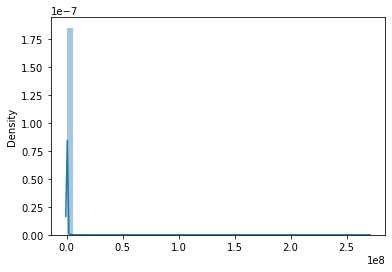

In [34]:
sns.distplot(btw)


*Strength* es la suma de los pesos de los vértices conectados al nodo.

In [35]:
st=ig.strength()
df_metrics['st'] = st


C:\Users\genes\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

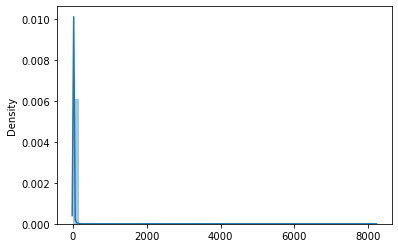

In [36]:
sns.distplot(st)


*Closeness* es el número de pasos necesarios para acceder a cualquier otro nodo desde el nodo.

In [37]:
closeness = ig.closeness()
df_metrics['closeness']  = closeness


C:\Users\genes\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

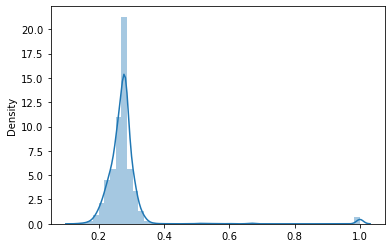

In [38]:
sns.distplot(closeness)


*Degree* es el numero de vértices conectados a un nodo, en este caso es la cantidad de personas que retuitearon el tuit de una persona.

In [39]:
degree = ig.degree()
df_metrics['degree'] = degree


C:\Users\genes\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

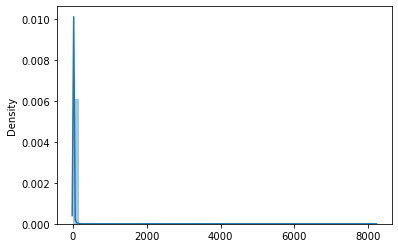

In [40]:
sns.distplot(degree)


*eigenvector centrality* Valores del primer vector propio de la matriz de adyacencia del gráfico. Los valores son altos para los vértices que están conectados a muchos otros vértices que, a su vez, están conectados a muchos otros, etc.

In [41]:
eigenvector_centrality = ig.eigenvector_centrality()
df_metrics['eigenvector_centrality'] = eigenvector_centrality


C:\Users\genes\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

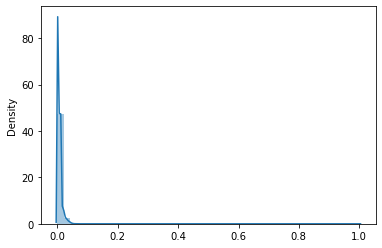

In [42]:
sns.distplot(eigenvector_centrality)


*page rank* La centralidad de PageRank de un vértice es la fracción de tiempo que un caminante aleatorio que atraviesa el gráfico pasaría en ese vértice

In [43]:
page_rank = ig.pagerank()
df_metrics['page_rank'] = page_rank


C:\Users\genes\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

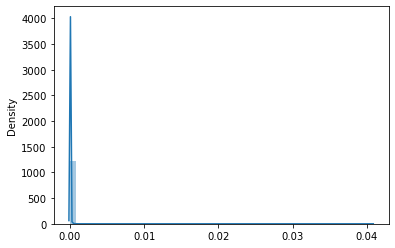

In [44]:
sns.distplot(page_rank)


*Harmonic centrality* no considera aquellos cuyo length sea mayor que el límite.

In [45]:
har_centr = ig.harmonic_centrality()
df_metrics['har_centr'] = har_centr


C:\Users\genes\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

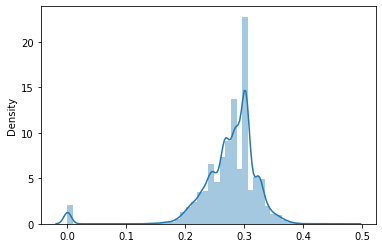

In [46]:
sns.distplot(har_centr)


In [47]:
df_metrics


,name,btw,st,closeness,degree,eigenvector_centrality,page_rank,har_centr
vertex ID,,,,,,,,
0,2737379453,78111.640852,9.0,0.244898,9,7.483957e-04,0.000038,0.250772
1,2258074658,130535.561685,19.0,0.286305,19,9.090829e-03,0.000070,0.307703
2,159909978,0.000000,1.0,0.196722,1,7.490374e-06,0.000007,0.198210
3,105301854,31376.713412,10.0,0.304398,10,1.069571e-02,0.000036,0.325685
4,290671142,291383.100735,15.0,0.308014,15,1.193750e-02,0.000056,0.329096
...,...,...,...,...,...,...,...,...
39795,1311418268205428739,0.000000,1.0,0.166180,1,6.266713e-08,0.000011,0.165806
39796,2650545267,0.000000,1.0,0.182163,1,1.736447e-06,0.000009,0.184600
39797,391590171,0.000000,1.0,1.000000,1,4.287612e-19,0.000025,0.000025


¿Están correlacionadas las medidas?

De los gráficos podemos decir que varios tienen una distribución de frecuencia similar. Vamos a generar un mapa de calor para corroborarlo.

<AxesSubplot:>

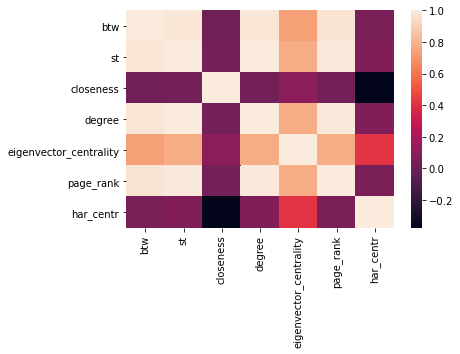

In [48]:
sns.heatmap(df_metrics.corr())

Podemos ver que cuatro de las métricas están fuertemente correlacionadas entre si: betweenness, degree, page rank y strength. Por otro lado eigenvecto centrality tiene una correlación media con los cuatro anteriores.

In [49]:
data = {}
for col in  ['btw', 'closeness', 'degree', 'eigenvector_centrality', 'page_rank', 'har_centr']:
    top = df_metrics.nlargest(10, columns=[col])[col].index
    data[col] = top

In [50]:
 pd.DataFrame(data)

,btw,closeness,degree,eigenvector_centrality,page_rank,har_centr
0,13,29638,13,13736,13,13
1,13736,29656,13736,8398,13736,13736
2,8398,29657,8398,13,8398,8398
3,13740,30425,11454,11454,13740,11454
4,30,30426,13740,13159,11454,4511
5,11454,30657,13159,13740,13159,30
6,13159,30954,30,13739,13734,6910
7,13734,30955,13734,13734,30,7977
8,13739,31274,13739,30,13739,2775
9,59,31275,13738,9068,13738,13159


Podemos ver qie hay fuerte coincidencia entre los primeros lugares, especialmente en las medidas que mostraban alta correlación. Los usuarios en las primeras 4-5 columnas no varían mucho entre medidas.

In [51]:
df_metrics.iloc[[20,15271,7996,13554,24746]]


,name,btw,st,closeness,degree,eigenvector_centrality,page_rank,har_centr
vertex ID,,,,,,,,
20,1003913378,6877.175297,26.0,0.297894,26,0.010618,0.000081,0.317468
15271,3247183779,6444.338199,4.0,0.308165,4,0.022697,0.000023,0.329100
7996,1566199123,0.000000,1.0,0.281730,1,0.007390,0.000008,0.302770
13554,403232552,0.000000,1.0,0.270762,1,0.009732,0.000009,0.286548
24746,1025505747734589440,8.538728,2.0,0.242240,2,0.000193,0.000012,0.247844


In [52]:
central_users =df[df['user.id'].isin(['252168075','130979339','73102744','367933714','593189095'])]

In [53]:
central_users.columns

Index(['created_at', 'id_str', 'full_text', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'user.id', 'user_retweeters', 'sentiment'],
      dtype='object')

In [54]:
central_users.fillna(0,inplace=True)

C:\Users\genes\anaconda3\lib\site-packages\pandas\core\frame.py:4462: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [55]:
central_users.groupby(by=['user.id','sentiment']).id_str.count()

user.id    sentiment 
130979339  0             1061
252168075  0             1948
           Apoyo            1
           Comentario       3
           Pregunta         1
367933714  0              776
           Comentario       6
593189095  0              402
           Comentario       1
73102744   0             2190
           Apoyo            2
           Comentario       3
Name: id_str, dtype: int64


Son usuarios con muchos tweets, de hecho el 73102744 que está en tercer lugar en casi todas las medidas de centralidad es el que más tuits publicó. No se puede decir nada sobre sus sentimientos pues no están todos tageados.

La gran mayoría de sus tuits son respuestas a otros usuarios

In [56]:
df1 = df.fillna(0).groupby(by=['user.id']).id_str.count()

In [57]:
df1.sort_values( ascending=False).head(15)

user.id
73102744               2195
252168075              1953
130979339              1061
2687724840              893
367933714               782
1077176953              410
593189095               403
312708081               290
3015178264              289
1273799426348331012     254
931564592328781824      243
956981248299282432      220
144929758               205
35680704                171
4343677427              167
Name: id_str, dtype: int64

In [58]:
df[df['user.id'].isin(['73102744'])].head(10)

,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
39,Sun Feb 28 23:51:37 +0000 2021,1366174247425556483,Argentina tiene hoy casi 18 muertos por millón...,NaN,NaN,73102744,"[178105343, 2644056245, 4196856351, 215547565,...",NaN
107,Mon Mar 01 05:09:45 +0000 2021,1366254308426207232,@arroadri Inevitable a menos que se aceleren l...,1366218359730241543,171893542,73102744,[1083825689848135680],NaN
111,Mon Mar 01 00:53:09 +0000 2021,1366189731235643394,"@jadagui un rato, me cayeron los violentos",1366184037543460865,139058257,73102744,[],NaN
114,Mon Mar 01 12:17:42 +0000 2021,1366362007063117827,@PTorricos Precisamente y cuidadosamente dije ...,1366357963099750404,1233442742312865792,73102744,[],NaN
116,Mon Mar 01 02:43:39 +0000 2021,1366217542889598977,@Horacio86925173 Puse candado para evitar a lo...,1366185744574930944,1351278834147069953,73102744,[],NaN
119,Mon Mar 01 00:05:53 +0000 2021,1366177838932631554,@cacerolapop 🥰,1366176472357101571,4497008602,73102744,[],NaN
120,Mon Mar 01 03:32:38 +0000 2021,1366229867675664384,@musa_nancy ❤️,1366229748498718720,1873909063,73102744,[],NaN
122,Mon Mar 01 03:49:05 +0000 2021,1366234007118225415,@musa_nancy Abrazo!,1366230372762218501,1873909063,73102744,[],NaN
124,Mon Mar 01 00:51:33 +0000 2021,1366189329543032840,"@vidal_aleta Se ve que no leiste nada, no te a...",1366186725341593601,984448926395793408,73102744,[],NaN
128,Mon Mar 01 00:57:15 +0000 2021,1366190763625873415,@vidal_aleta No leíste el hilo completo y diji...,1366190098119860226,984448926395793408,73102744,[],NaN


Respecto al contenido de sus tuits podemos ver que en muchos casos son respuestas a otros usuarios, o a si mismos.

#### **3. Comunidades**

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

**Opcional:** Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.

In [59]:
from cdlib import NodeClustering, evaluation, algorithms


ModuleNotFoundError: No module named 'cdlib'

In [80]:
resolutions = [0.1, 1, 10]
comms_dict = {}
for resolution in resolutions:
    comms = algorithms.louvain(G, weight='weight', resolution=resolution, randomize=False)
    comms_dict[resolution] = comms 



NameError: name 'algorithms' is not defined

*Modularidad* Diferenciar la fracción de bordes intracomunitarios de una partición con el número esperado de tales bordes si se distribuye de acuerdo con un modelo nulo.

In [ ]:
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(G, comms_dict[0.1]))
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(G, comms_dict[1]))
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(G, comms_dict[10]))

Con distintas resoluciones, la medida de modularidad aumenta, pero no linealmente.

*Indice de corte* El ratio de nodos en el borde de la comunidad.

In [ ]:
print('Comunidades encontradas:', evaluation.cut_ratio(G, comms_dict[0.1]))
print('Comunidades encontradas:', evaluation.cut_ratio(G, comms_dict[1]))
print('Comunidades encontradas:', evaluation.cut_ratio(G, comms_dict[10]))

En todos los casos el mínimo de nodos es el mismo, y es máximo cuando resolution es 1.

*Densidad interna* Densidad de nodos internos

In [ ]:
print('Comunidades encontradas:', evaluation.internal_edge_density(G, comms_dict[0.1]))
print('Comunidades encontradas:', evaluation.internal_edge_density(G, comms_dict[1]))
print('Comunidades encontradas:', evaluation.internal_edge_density(G, comms_dict[10]))

La densidad es mayor cuanto más grandes son las comunidades. Y la densidad interna indica que las comunidades son mas robustas cuanto mas grandes.

### Label propagation

In [ ]:
def get_communidades_cdlib(communidades):

    comm = communidades.communities
    
    values = [] 

    for value in comm:

        values.append([value , len(value) ])
        df = pd.DataFrame(values, columns = [ 'miembros' , 'cantidad'])

    return df

In [ ]:
lp= algorithms.label_propagation(G)

In [ ]:
len(lp.communities)


In [ ]:
df = get_communidades_cdlib(lp)
sorted_df = df.sort_values(axis=0, by=['cantidad'] , ascending=False)
sorted_df[:10]

Con label propagation se encontraron 1039 comunidades con tamaños muy variables.

In [ ]:
evaluation.internal_edge_density(G,lp )


Se recalcula Louvain

In [ ]:
comms = algorithms.louvain(G, resolution=2, randomize=False)
comm_df = pd.DataFrame({
    "communities": comms.communities,
    "comm_id": np.arange(0, len(comms.communities))
})
comm_df = comm_df.assign(comm_size=comm_df["communities"].apply(lambda c: len(c)))
comm_df.to_csv('comm_df.csv')

Según la medida de densidad interna las comunidades encontradas son buenas.

## Segunda parte

### **4. Extracción de etiquetas**

En el archivo [etiquetas.csv](https://drive.google.com/file/d/1LWY3VoIRt0xKwEbbtMXYePOGZvgPsQh-/view?usp=sharing) están las etiquetas para un pequeño subconjunto de nodos. Podemos interpretar el valor de la etiqueta como la pertenencia a una determinada clase, donde los usuarios de una misma clase en general tienden a expresar apoyo entre sí.

- Determinar quiénes son los usuarios referentes de cada clase (utilizar alguna medida de centralidad calculada sobre el grafo de retweets).
- Utiliando los resultados del práctico anterior, determinar si los usuarios de cada clase forman parte de distintas comunidades.

**Opcional:** Reconstruir el archivo "etiquetas.csv". Para eso, hacer lo siguiente

- Construir un grafo en donde los nodos sean usuarios, y donde los enlaces unan dos nodos si entre ellos hubo más respuestas de apoyo que de oposición.
- Extraer las dos componentes más grandes del grafo. Esos serán nuestros nodos etiquetados.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import math
import igraph as ig
import networkx as nx
import pickle

from nltk import (corpus, tokenize, download)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
download("stopwords")
download('punkt')

In [60]:
DATASET_FILE = "etiquetas.csv"

dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str}
    
df_etiq = pd.read_csv(DATASET_FILE, dtype=dtypes)
df_etiq= df_etiq.rename(columns={'user.id':'user'})

In [61]:
df_etiq.Clase.value_counts()

0    107
1     89
Name: Clase, dtype: int64

In [62]:
df_etiq

,user,Clase
0,1227432088925851650,0
1,1148843472,0
2,1329815581302853632,0
3,131669966,0
4,811607948,0
...,...,...
191,15750760,1
192,882731195834003457,1
193,164350783,1
194,1249892637085237258,1


In [70]:
df_etiq = pd.merge(df_etiq, df_metrics, left_on='user', right_on='name', how='left')
df_etiq= df_etiq.dropna()

In [71]:
df_etiq.Clase.value_counts()

0    94
1    89
Name: Clase, dtype: int64

In [72]:
df_etiq

,user,Clase,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment,name,btw,st,closeness,degree,eigenvector_centrality,page_rank,har_centr
2,1329815581302853632,0,Mon Feb 01 03:41:14 +0000 2021,1356085171875958790,"@spitta1969 @IrisScarpinelli Ah joder, derechi...",1355984123261820938,252168075,1329815581302853632,[],Apoyo,1329815581302853632,0.000000,1.0,0.281730,1.0,0.007390,0.000008,0.302770
4,811607948,0,Sun Feb 07 23:39:35 +0000 2021,1358561072039526400,@spitta1969 La épica del contrafáctico 🤦‍♂️,1358556988423176192,252168075,811607948,[],Apoyo,811607948,84.061668,5.0,0.299659,5.0,0.008352,0.000019,0.318728
5,811960507829800960,0,Thu Jan 14 11:16:04 +0000 2021,1349676652473819136,@spitta1969 Pero porque nos empecinamos en lla...,1349375492076535808,252168075,811960507829800960,[],Apoyo,811960507829800960,39225.262366,7.0,0.240540,7.0,0.000688,0.000031,0.247890
6,3108851163,0,Wed Jan 20 23:28:04 +0000 2021,1352035194539274254,@spitta1969 El Anmat autorizo el suero equino ...,1352021671612456961,252168075,3108851163,"[1303185099974942720, 2288939745, 1372493378, ...",Apoyo,3108851163,87364.145848,41.0,0.310966,41.0,0.013261,0.000134,0.329604
7,34811840,0,Mon Feb 01 21:37:59 +0000 2021,1356356145523392517,@spitta1969 Cuantos $$$ vale tu reputación y t...,1356256145145548802,252168075,34811840,[],Apoyo,34811840,0.000000,1.0,0.256288,1.0,0.000225,0.000007,0.259117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,997060027147055104,1,Sun Mar 07 09:25:04 +0000 2021,1368492886380187648,@ernestorr No nos olvidamos pedazo de sorete h...,1368374365956538370,73102744,997060027147055104,[],Apoyo,997060027147055104,4.228002,2.0,0.233815,2.0,0.000194,0.000013,0.240751
222,1183974626,1,Sat Mar 06 21:52:52 +0000 2021,1368318691792797698,@ernestorr @LANACION Hay que pegarle al chanch...,1368314581592981505,73102744,1183974626,[],Apoyo,1183974626,22129.824556,8.0,0.329796,8.0,0.036212,0.000040,0.353427
223,15750760,1,Sat Feb 06 16:55:07 +0000 2021,1358096900235395079,@ernestorr Acá los ignorantes dicen que dos pa...,1358094824239464453,73102744,15750760,[1218297326709723136],Apoyo,15750760,0.000000,1.0,0.252714,1.0,0.000310,0.000008,0.258294
224,882731195834003457,1,Sun Mar 07 13:49:59 +0000 2021,1368559556733902852,@ernestorr @LANACION Y quitaron vacuna del cal...,1368314581592981505,73102744,882731195834003457,[],Apoyo,882731195834003457,0.000000,1.0,0.260124,1.0,0.000498,0.000008,0.264777


In [73]:
#Usuarios referentes de cada clase
#Primero, clase 0
columns=['degree','eigenvector_centrality','page_rank','har_centr', 'btw']
data = {}
for col in columns:
    top_users = df_etiq[df_etiq['Clase'] == 0].nlargest(5, columns=[col])['user'].tolist()
    data[col] = top_users
pd.DataFrame(data)

,degree,eigenvector_centrality,page_rank,har_centr,btw
0,252168075,252168075,252168075,252168075,252168075
1,252168075,252168075,252168075,252168075,252168075
2,252168075,252168075,252168075,252168075,252168075
3,252168075,252168075,252168075,252168075,252168075
4,252168075,252168075,252168075,252168075,252168075


In [75]:
#Luego, vemos clase 1
columns=['degree','eigenvector_centrality','page_rank','har_centr', 'btw']
data = {}
for col in columns:
    top_users = df_etiq[df_etiq['Clase'] == 1].nlargest(5, columns=[col])['user'].tolist()
    data[col] = top_users
pd.DataFrame(data)

,degree,eigenvector_centrality,page_rank,har_centr,btw
0,73102744,73102744,73102744,73102744,73102744
1,73102744,73102744,73102744,73102744,73102744
2,73102744,73102744,73102744,73102744,73102744
3,73102744,73102744,73102744,73102744,73102744
4,73102744,73102744,73102744,73102744,73102744


In [89]:
comm_df = pd.read_csv('comm_df.csv')

In [101]:
#Indentificar diferentes comunidades
com_1 = (comm_df["communities"][0])
com_2 = (comm_df["communities"][1])

In [91]:
clase_0 = list(df_etiq[df_etiq['Clase'] == 0]['user'])
clase_1 = list(df_etiq[df_etiq['Clase'] == 1]['user'])

In [105]:
#Q de usuarios de la clase 1 que están dentro de la comunidad 1
len([x for x in clase_1 if x in com_1])

86

In [106]:
#Q de usuarios de la clase 0 que están dentro de la comunidad 2
len([x for x in clase_0 if x in com_2])

94

In [107]:
#Se exporta el df para ser utilizado en Ejercicio 5
df_etiq.to_csv('etiq.csv')

In [110]:
com_1

"['73102744', '178105343', '2644056245', '4196856351', '146536143', '1873762824', '110184114', '306513842', '1458246122', '1178090455927525383', '67175765', '402176767', '4618715801', '4340256801', '1290011392016351233', '727296065926496265', '850481701000237056', '4758703641', '1352733531630432256', '585205927', '1083825689848135680', '2612402816', '107442800', '2152001791', '791699809279287296', '312183888', '2780654617', '220457693', '1702761704', '434981389', '207217115', '158007051', '1038538969389182976', '3231977118', '186881299', '2434585328', '2662139235', '500269004', '2838925913', '450679943', '1183456464691707904', '1091857643298275328', '1110278617735589889', '712039945695862790', '3305130695', '826799015828275202', '574739820', '1959396680', '719331994665099264', '219979521', '955257133', '3399185962', '2536115590', '995474438031400960', '364517397', '1226291886517866496', '1062720837759815682', '4251243893', '152770378', '109567765', '624282243', '225285449', '381507284'

In [112]:
#Se exportan los csv para ambas comunidades
comm_1 = pd.DataFrame(eval(com_1)).rename(columns={0:'comm_1'})
comm_1.to_csv('comm_1.csv')
comm_2 = pd.DataFrame(eval(com_2)).rename(columns={0:'comm_2'})
comm_2.to_csv('comm_2.csv')